# Train smarter Naive Bayes model with labelled data

The running of this script creates new pickle object with Naive Bayes model. Periodically run the notebook and replace the pickle file in object with a new one as it only gets better with more data.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline

In [2]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/vlado/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('long_articles.csv', header=None)
df.columns = ['index','date', 'text', 'naive_bayes_label', 'neural_net_label', 'checked_label']
df = df[['text', 'checked_label']]
df = df.dropna()
df.shape

(957, 2)

In [4]:
df2 = pd.read_csv('long_articles2.csv', header=None)
df2.columns = ['index', 'date', 'text', 'naive_bayes_label', 'neural_net_label', 'checked_label']
df2 = df2[['text', 'checked_label']]
df2 = df2.dropna()
df2.shape

(100, 2)

In [5]:
df3 = pd.read_csv('news.csv', header=None)
df3.columns = ['index', 'date', 'title', 'text', 'naive_bayes_label', 'neural_net_label', 'checked_label']
df3 = df3[['text', 'checked_label']]
df3 = df3.dropna()
df3.shape

(280, 2)

In [6]:
df = df.append(df2).append(df3)
df

,text,checked_label
0,You could the logic of broken precedent of ass...,general
1,The base protocol uses 32 ETH for technical re...,finance
2,This is one of the worst tools I&#x27;ve ever ...,web/mobile
3,Do other message protocols &#x2F; apps solve t...,web/mobile
4,The heat and noise was what led me to sell my ...,general
...,...,...
275,As a web developer you can build small website...,web/mobile
276,I got bug bites at Airbnb. Doctor says its bed...,web/mobile
277,Hey! Hope everyone is doing great today :)<p>G...,web/mobile
278,"This question is just a musing, a &quot;shower...",web/mobile


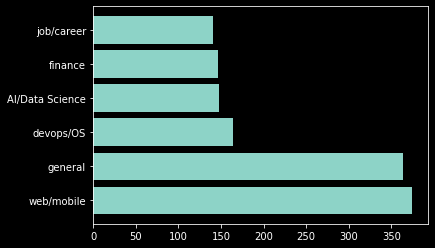

In [7]:
plt.figure(figsize=[6,4])
plt.barh(df['checked_label'].value_counts().index, df['checked_label'].value_counts())
plt.grid(False);

We are going to have to clean the junk out of the text.

In [8]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\d', '', text)
    text = re.sub(r"&#x27;", "", text)
    text = re.sub(r"&gt;", "", text)
    text = re.sub(r"&#x2F;", "", text)
    text = re.sub(r"<[^>]*>", "", text)
    text = text.strip(' ')
    return text

def remove_stopwords(row):
    final_row = [w for w in row.split(' ') if w not in stopwords.words('english')]
    final_row = ' '.join(final_row)
    return final_row


In [9]:
df['text'] = df['text'].map(clean_text)
df['text'] = df['text'].map(remove_stopwords)

In [10]:
df

,text,checked_label
0,could logic broken precedent assumed safety pe...,general
1,base protocol uses eth technical reasons yes ...,finance
2,one worst tools x ever used tried hard year be...,web/mobile
3,message protocols xf apps solve meta data prob...,web/mobile
4,heat noise led sell quot mbp favour quot air...,general
...,...,...
275,web developer build small websites mobile app ...,web/mobile
276,got bug bites airbnb doctor says bed bugs host...,web/mobile
277,hey hope everyone great today p guys one month...,web/mobile
278,question musing quot shower thought quot p js ...,web/mobile


## Tf-IDF

Here we use Tf IDf which is a method based mainly on the frequency of the words. It's very good with the simpler models that we will be creating  here. 

In [11]:
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(df['text'])

In [12]:
x_train = x_train.toarray()

In [13]:
df['checked_label'].unique()

array(['general', 'finance', 'web/mobile', 'devops/OS', 'job/career',
       'AI/Data Science'], dtype=object)

In [14]:
df['checked_label'] = df['checked_label'].map({'AI/Data Science': 0, 'devops/OS': 1, 'finance': 2, 
                                               'general': 3, 'job/career': 4,  'web/mobile': 5})
y_train = df['checked_label'] 

In [15]:
x_train.shape, y_train.shape

((1337, 11747), (1337,))

## Split into train - test 


In [16]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [17]:
x_train.shape, y_train.shape

((1069, 11747), (1069,))

In [18]:
x_test.shape, y_test.shape

((268, 11747), (268,))

## Naive Bayes

Very good with text data, sparse matrices and tf-idf.

In [19]:
params = {'alpha': [0, 0.2, 0.5, 0.7, 1, 2, 5], 'norm': [True, False]}

In [20]:
grid = GridSearchCV(ComplementNB(), param_grid = params, n_jobs= -1)
grid.fit(x_train, y_train)
best_scores = grid.best_params_
best_scores

{'alpha': 0.5, 'norm': False}

In [21]:
nb = ComplementNB(alpha = best_scores['alpha'], norm = best_scores['norm'])

In [22]:
nb.fit(x_train, y_train)

ComplementNB(alpha=0.5)

In [23]:
preds = nb.predict(x_test)

In [24]:
def print_metrics(model, predictions):
    print(f'Train Accuracy: {model.score(x_train, y_train)}')
    print(f'Test Accuracy: {model.score(x_test, y_test)}')
    print(f'F1 score: {f1_score(predictions, y_test, average = "weighted")}')

In [25]:
print_metrics(nb, preds)

Train Accuracy: 0.990645463049579
Test Accuracy: 0.6828358208955224
F1 score: 0.6897552584569241


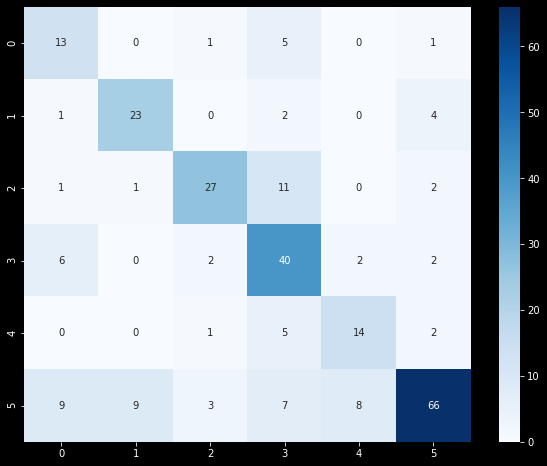

In [26]:
def show_confusion_matrix(predictions):
    conf_matrix = confusion_matrix(predictions, y_test)
    plt.figure(figsize=[10,8])
    sns.heatmap(conf_matrix, annot = True, fmt ='d',cmap = 'Blues');

show_confusion_matrix(preds)

## Save model

Let's create a pipeline that will ease the model when serves in production.

In [27]:
pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('nb', ComplementNB())])
pipe.fit(df['text'] , df['checked_label'] )

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('nb', ComplementNB())])

In [28]:
def test_with_random_text(txt):
    txt = clean_text(txt)
    txt = remove_stopwords(txt)
    pred = pipe.predict([txt])
    return pred

In [29]:
pred = test_with_random_text('Windows is the worst OS there is. I hope people will soon see the excelence of Linux')
pred

array([1])

In [30]:
pred = test_with_random_text('This is all about politics.This is not in our labels so it should be general')
pred

array([3])

In [31]:
pred = test_with_random_text('AWS is the first cloud provider that i can think of. The label should be one')
pred

array([1])

In [32]:
import pickle
save_classifier = open("nb_topic_classifier.pickle","wb")
pickle.dump(pipe, save_classifier)
save_classifier.close()